# Clasificación de textos con 🤗 Transformers

> Cómo afinar un modelo de RoBERTa en español para clasificar las reseñas de Amazon.

## Configuración

Si está ejecutando este notebook en Google Colab, ejecute la siguiente celda para instalar las bibliotecas que necesitamos:

In [ ]:
!pip install transformers datasets

Para compartir tu modelo con la comunidad, primero crea una cuenta en el [Hugging Face Hub](https://huggingface.co/join). A continuación, ejecute la siguiente celda y proporcione su nombre de usuario y contraseña para generar un token de autenticación:

In [ ]:
# Esto sólo funciona en Google Colab! Para los notebooks normales, es necesario ejecutar esto en el terminal
!huggingface-cli login

Si no tienes instalado [Git LFS](https://git-lfs.github.com), puedes hacerlo descomentando y ejecutando la celda de abajo:

In [ ]:
# !apt install git-lfs
# !git config --global user.email "you@example.com"
# !git config --global user.name "Your Name"

## Cargar y explorar los datos

Utilizaremos 🤗 Datasets para cargar y procesar nuestro conjunto de datos. Si no está familiarizado con 🤗 Datasets, vea el siguiente vídeo :)

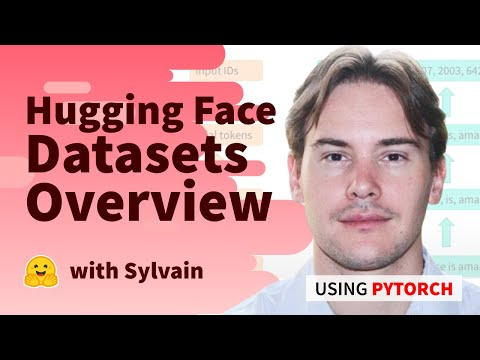

In [5]:
from IPython.display import YouTubeVideo

YouTubeVideo("_BZearw7f0w", width=600, height=400)

In [1]:
from datasets import load_dataset

dataset = load_dataset("amazon_reviews_multi", "es")
dataset

Reusing dataset amazon_reviews_multi (/home/lewis/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
})

In [3]:
import random
import pandas as pd
from datasets import ClassLabel
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    "Taken from https://github.com/huggingface/notebooks/blob/master/examples/text_classification.ipynb"
    
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

show_random_elements(dataset["train"])

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0282471,product_es_0828344,reviewer_es_0284535,3,"poca protección (espumas delgadas) tamaño correcto para bajo tipo jazz bass. las cremalleras se ven débiles (la del bolsillo se atasca un poco ya de nuevo) bolsillo simbólico, lo que pongas en el contacta casi directamente con el bajo. correas ajustables y cómodo de llevar en espalda. Si lo requieres para transportar en espalda sin necesidad de mucha protección es válido, pesa poco.",Cumple justito,es,musical_instruments
1,es_0610398,product_es_0412748,reviewer_es_0060942,3,Me ha gustado mucho la presentacion y los.aromas X lo q no doy 5 es xq un frasco venia.abierto y medio vacio,Calidad precio buena,es,drugstore
2,es_0869976,product_es_0779517,reviewer_es_0113188,3,"La pieza viene muy bien pero no me gusta la presentación por que era para un regalo y venia en una bolsita de plástico por lo menos podían poner un saquito de terciopelo de los que ponen en joyería donde vende Pandora , tuve que ir a g buscar cajitas de regalo para joyas que es otro gasto más que fuera echo falta si lo fuera comprado en joyeria y no se si será original por no trae un certificado como otras piezas",Raúl L.,es,jewelry
3,es_0916971,product_es_0506933,reviewer_es_0265333,5,Hasta el momento todo ha ido perfecto. Producto de calidad que cumple con lo prometido,Gran acierto,es,toy
4,es_0850186,product_es_0595711,reviewer_es_0045447,1,No puedo opinar de la calidad. Lo tuve que devolver porque lo que recibí no era lo publicitado. El que me enviaron tenía dos mandos individuales y no uno solo. El servicio de devolución como siempre sin problemas.,Tuve que devolverlo,es,personal_care_appliances
5,es_0360116,product_es_0654936,reviewer_es_0293116,2,Los hemos tenido que devolver ya que no sonaban en estero y presentaban deficiencias,Tienen que mejorarlos,es,wireless
6,es_0020652,product_es_0636725,reviewer_es_0062476,5,Cumple con su cometido sin más materiales de calidad,Cumple con su cometido,es,home
7,es_0448974,product_es_0703134,reviewer_es_0795225,1,"Me ha llegado el producto hace 5 días. No funciona, no arranca. Probe en distintos tomas que se que funcionan y nada. Solicite la devolución y aun no se han puesto en contacto conmigo. Lamentable.",No funciona,es,home
8,es_0170254,product_es_0356528,reviewer_es_0800691,1,"Muy mala calidad. Lo instalé y a día siguiente el eje de apoyo doblado, no aguanta bien el peso. Solo para dejar fija. No lo recomiendo",Baja calidad,es,electronics
9,es_0488278,product_es_0295588,reviewer_es_0297624,4,Un poco grandes. Quedan en la mano holgados a pesar d ser mi talla.dan más talla de lo habitual....una más.,Dan mucha tallA,es,sports


In [4]:
dataset.set_format("pandas")
df = dataset["train"][:]
df.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


In [5]:
df["product_category"].value_counts()

home                        26962
wireless                    25886
toy                         13647
sports                      13189
pc                          11191
home_improvement            10879
electronics                 10385
beauty                       7337
automotive                   7143
kitchen                      6695
apparel                      5737
drugstore                    5513
book                         5264
furniture                    5229
baby_product                 4881
office_product               4771
lawn_and_garden              4237
other                        3937
pet_products                 3713
personal_care_appliances     3573
luggage                      3328
camera                       3029
shoes                        2754
digital_ebook_purchase       1843
video_games                  1733
jewelry                      1598
musical_instruments          1530
watch                        1490
industrial_supplies          1482
grocery       

In [6]:
df["stars"].value_counts()

1    40000
2    40000
3    40000
4    40000
5    40000
Name: stars, dtype: int64

In [7]:
dataset.reset_format()

## Fusionar las clasificaciones por estrellas

In [8]:
dataset = dataset.filter(lambda x : x["stars"] != 3)

Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-9593cf0948d4f539.arrow
Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-48e312ff9c17ae46.arrow
Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-22bca18e576e3ef2.arrow


In [9]:
def merge_star_ratings(examples):
    if examples["stars"] <= 2:
        label = 0
    else:
        label = 1
    return {"labels": label}

In [10]:
dataset = dataset.map(merge_star_ratings)

Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-bcdebbad383c8b3f.arrow
Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-4ceba60057897618.arrow
Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-8afdc3fe1e246b00.arrow


In [11]:
show_random_elements(dataset["train"], num_examples=3)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,labels
0,es_0612794,product_es_0389112,reviewer_es_0217587,4,Cubre casi como un maquillaje y con protección solar. Crema fluida.,Buena compra,es,beauty,1
1,es_0554680,product_es_0467320,reviewer_es_0547677,1,"No afila como dicen y una de las piezas que afila se desplazo de su sitio en unas 3 semanas, ahora ya no hace nada",Mal Resultado,es,home,0
2,es_0302644,product_es_0500629,reviewer_es_0350316,1,"Pésimo, no se adapta bien porque no cubre toda la pantalla y no cubre la parte redonda de la pantalla y se queda al aire por donde entrar polvo. Al no ajustar bien hay puntos donde el táctil no funciona y encima el reconocimiento por huella dactilar no te reconoce. No recomiendo para nada su compra, es tirar el dinero -10 de 10. De que sirve un protector si luego la pantalla no funciona bien.",Protector pesimo,es,wireless,0


## Tokenizar las reseñas

In [4]:
from transformers import AutoTokenizer

model_checkpoint = "BSC-TeMU/roberta-base-bne"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

## Tokenización de las reseñas

Para entender la siguiente sección, vea este breve vídeo sobre la tokenización:

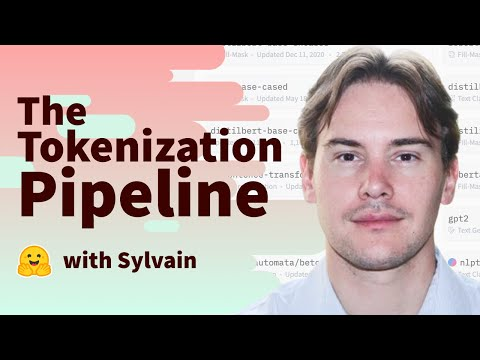

In [7]:
YouTubeVideo("Yffk5aydLzg", width=600, height=400)

In [13]:
tokenizer.vocab_size

50262

In [14]:
text = "¡hola, me llamo lewis!"
tokenized_text = tokenizer.encode(text)

for token in tokenized_text:
    print(token, tokenizer.decode([token]))

0 <s>
1465 ¡
12616 hola
66 ,
503  me
17111  llamo
532  le
19514 wis
55 !
2 </s>


In [15]:
encoded_text = tokenizer(text, return_tensors="pt")
encoded_text

{'input_ids': tensor([[    0,  1465, 12616,    66,   503, 17111,   532, 19514,    55,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [16]:
def tokenize_reviews(examples):
    return tokenizer(examples["review_body"], truncation=True)

In [17]:
columns = dataset["train"].column_names
columns.remove("labels")
encoded_dataset = dataset.map(tokenize_reviews, batched=True, remove_columns=columns)
encoded_dataset

Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-fd6211328c270752.arrow
Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-310f36bb4cf95611.arrow
Loading cached processed dataset at /home/lewis/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-27c48d0c72d51279.arrow


DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 160000
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 4000
    })
})

In [18]:
encoded_dataset["train"][0]

{'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'input_ids': [0,
  10626,
  3383,
  361,
  503,
  847,
  36181,
  4747,
  334,
  1111,
  313,
  1369,
  1635,
  342,
  403,
  1594,
  4162,
  2957,
  369,
  10925,
  2],
 'labels': 0}

## Cargar el modelo preentrenado

In [5]:
from transformers import AutoModelForSequenceClassification

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Some weights of the model checkpoint at BSC-TeMU/roberta-base-bne were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at BSC-TeMU/roberta-base-bne and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bi

### De las input IDs a los hidden states

In [20]:
outputs = model(**encoded_text)
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[0.1087, 0.0641]], grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)

## Definir las métricas de rendimiento

In [21]:
from datasets import load_metric 

metric = load_metric("accuracy")
metric

Metric(name: "accuracy", features: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}, usage: """
Args:
    predictions: Predicted labels, as returned by a model.
    references: Ground truth labels.
    normalize: If False, return the number of correctly classified samples.
        Otherwise, return the fraction of correctly classified samples.
    sample_weight: Sample weights.
Returns:
    accuracy: Accuracy score.
Examples:

    >>> accuracy_metric = datasets.load_metric("accuracy")
    >>> results = accuracy_metric.compute(references=[0, 1], predictions=[0, 1])
    >>> print(results)
    {'accuracy': 1.0}
""", stored examples: 0)

In [22]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

## Afinar el modelo preentrenado

Si quiere entender más profundamente cómo funciona el Entrenador, vea el siguiente vídeo:

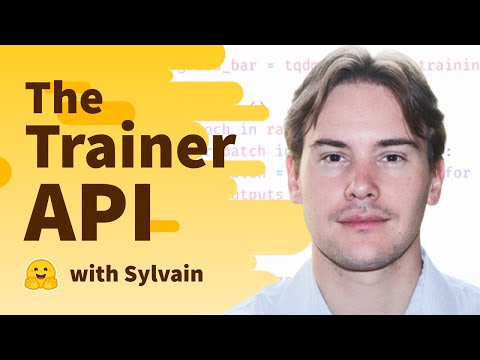

In [8]:
YouTubeVideo("nvBXf7s7vTI", width=600, height=400)

In [23]:
from transformers import TrainingArguments

model_name = model_checkpoint.split("/")[-1]

batch_size = 16
num_train_epochs=2
num_train_samples = 20_000
train_dataset = encoded_dataset["train"].shuffle(seed=42).select(range(num_train_samples))
logging_steps = len(train_dataset) // (2 * batch_size * num_train_epochs)

training_args = TrainingArguments(
    output_dir="results",
    num_train_epochs=num_train_epochs,     
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch", 
    logging_steps=logging_steps,
    push_to_hub=True,
    push_to_hub_model_id=f"{model_name}-finetuned-amazon_reviews_multi"
)

Loading cached shuffled indices for dataset at /home/lewis/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-98a28664b1adea9d.arrow


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    args=training_args, 
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer
)

In [25]:
trainer.train()

***** Running training *****
  Num examples = 20000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1250
/home/lewis/miniconda3/envs/hf/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.177600,0.176088,0.929500
2,0.092400,0.200465,0.930750


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 32
Saving model checkpoint to results/checkpoint-625
Configuration saved in results/checkpoint-625/config.json
Model weights saved in results/checkpoint-625/pytorch_model.bin
tokenizer config file saved in results/checkpoint-625/tokenizer_config.json
Special tokens file saved in results/checkpoint-625/special_tokens_map.json
/home/lewis/miniconda3/envs/hf/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 32
Saving model checkpoint to results/checkpoint-1250
Configuration saved in results/checkpoint-1250/config.json
Model weights saved in results/checkpoint-1250/pytorch_model.bin
tokenizer config file saved in results/checkpoint-1250/tokenizer_c

TrainOutput(global_step=1250, training_loss=0.1513079273223877, metrics={'train_runtime': 223.1055, 'train_samples_per_second': 179.287, 'train_steps_per_second': 5.603, 'total_flos': 2744100307436160.0, 'train_loss': 0.1513079273223877, 'epoch': 2.0})

## Empuje hacia el Hugging Face Hub

Para más detalles sobre el envío de modelos al Hub, vea el siguiente vídeo:

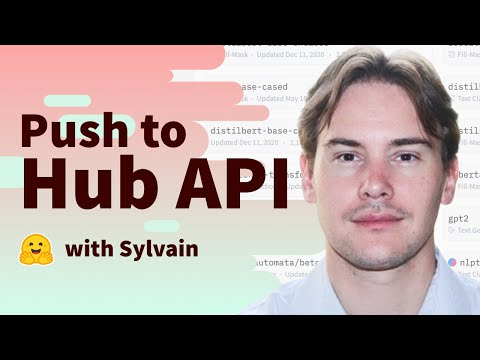

In [10]:
YouTubeVideo("A5IWIxsHLUw", width=600, height=400)

In [26]:
trainer.push_to_hub()

Saving model checkpoint to results
Configuration saved in results/config.json
Model weights saved in results/pytorch_model.bin
tokenizer config file saved in results/tokenizer_config.json
Special tokens file saved in results/special_tokens_map.json


'https://huggingface.co/lewtun/roberta-base-bne-finetuned-amazon_reviews_multi/commit/0e74f9c0068eb69400f45fab3e89242b3ecd85f0'

## Descargue el modelo desde el Hub

In [7]:
from transformers import pipeline

model_checkpoint = "lewtun/roberta-base-bne-finetuned-amazon_reviews_multi"
pipe = pipeline("sentiment-analysis", model=model_checkpoint)

In [8]:
pipe("¡me encanta el ipad!")

[{'label': 'LABEL_1', 'score': 0.9972302913665771}]